<a href="https://colab.research.google.com/github/mannixp/Plumes/blob/main/Plume_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1**

In this notebook we outline how to use a basic 3 equation plume theory model to predict layered stratifications arising from a number of point sources and sinks.


We load the neccessary libraries, specifiy the domain $z \in [0,1]$ and the differentiation matrices $D = d/dz$ and $L = d^2/dz^2$.

In [2]:
from scipy.integrate   import solve_ivp
from scipy.ndimage     import gaussian_filter
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

ε    = 1e-12
Npts = 64

z = np.linspace(0+ε,1-ε,Npts)

I = np.eye(Npts) # I
D = np.zeros((Npts,Npts)) # D = d/dz
L = np.zeros((Npts,Npts)) # L = d2/dz2
for i,z_i in enumerate(z):

    if i == 0:
      #D
      D[i,i+1] =  1

      #L
      L[i,i  ] = -2
      L[i,i+1] =  2 # if db/dz = 0
    elif i == Npts-1:
      #D
      D[i,i-1] = -1

      # L
      L[i,i-1] =  2 # if db/dz = 0
      L[i,i  ] = -2
    else:
      # D
      D[i,i-1] = -1
      D[i,i+1] =  1

      # L
      L[i,i-1] =  1
      L[i,i  ] = -2
      L[i,i+1] =  1

dz = z[1] - z[0]
L /= dz**2
D /= 2*dz

From the plume equations
\begin{align*}
\frac{dQ}{dz} &= 2 \sqrt{\pi} \alpha M^{1/2}, \\
\frac{dM}{dz} &= \frac{F Q}{M}, \\
\frac{dF}{dz} &= -\frac{d b}{d z} Q,
\end{align*}
where $F(z), Q(z)$ and $M(z)$ are the horizontally averaged (steady) buoyancy flux, volume flux and momentum flux respectively. This model contains two free parameters the Buoyancy frequency $N^2(z) = \frac{d b}{d z}$ which characterises the background vertical stratification and the entrainment coefficient $\alpha$. As the role of this parameter will change depending on the plume height we use the model
\begin{equation}
\alpha = -\frac{3}{8}\delta + \frac{1}{4}\frac{F Q^2}{M^{5/2}},
\end{equation}
where $\delta < 0$ is the dimensionless turbulence production coefficient and the second term is proportional to the Richardson number $Ri$. Using this entrainment model the plume equations are implemented below.

In [3]:
def plume_eqns(z,X,dbdz,δ):

    F,Q,M = X

    α    = -(3/8)*δ + (1/4)*( (F * Q**2)/M**2.5 )

    dFdz = -dbdz(z)*Q;
    dQdz = 2*α*np.sqrt(np.pi)*(M**0.5)
    dMdz = (F*Q)/M

    return [dFdz,dQdz,dMdz]

To solve these equations we first set up an ode solver using scipy, which takes the initial conditions
\begin{align*}
F &= F_0, \\
Q &= Q_0, \\
M &= M_0,
\end{align*}
at $z=0$ for a rising plume. The equations are then solved from $z=0 \to 1$ until $F=0$ at which point the integration is terminated. This corresponds to the plume attaining its neutrally buoyant height. For a descending plume we specifiy the above conditions at $z=1$, which requires making the transform $z \to 1-z$ and then integrating from $z=1 \to 0$ until $F=0$.

In [4]:
def Plume_Solve(F0,Nsq,δ=-0.25):

    # zero crossing
    def event(t,y,*args): return y[0];
    event.terminal = True;
    event.positive = 0

    # Flip the stratifictaion around
    if F0 < 0:
      Nsq = Nsq[::-1]

    # Solver
    dbdz = interp1d(z,Nsq,fill_value="extrapolate")
    sol  = solve_ivp(fun=plume_eqns,t_span=[z[0],z[-1]], y0=[abs(F0),ε,ε], t_eval=z,args=(dbdz,δ),events=event,rtol=1e-01,atol=1e-02)

    # Parse into entire domain
    F = 0.*z;
    Q = 0.*z;
    if F0 > 0.:
      F[0:len(sol.y[0])] = sol.y[0]
      Q[0:len(sol.y[1])] = sol.y[1]
    elif F0 < 0.:
      F[Npts-len(sol.y[0]):] =     sol.y[0][::-1]
      Q[Npts-len(sol.y[1]):] = -1.*sol.y[1][::-1]

    return F,Q

Generate rising and descending plumes

F1 0.1


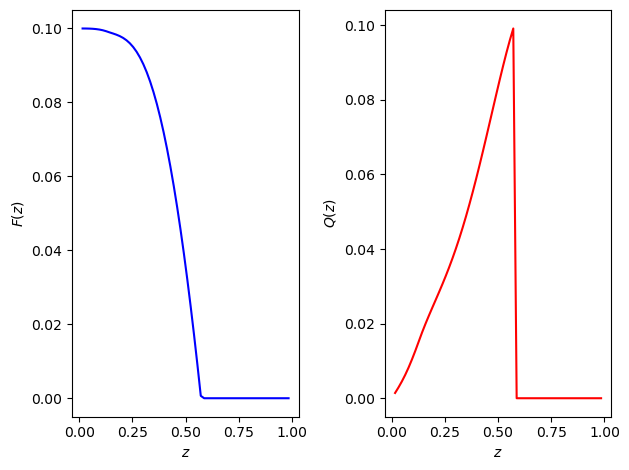

F2 -0.1


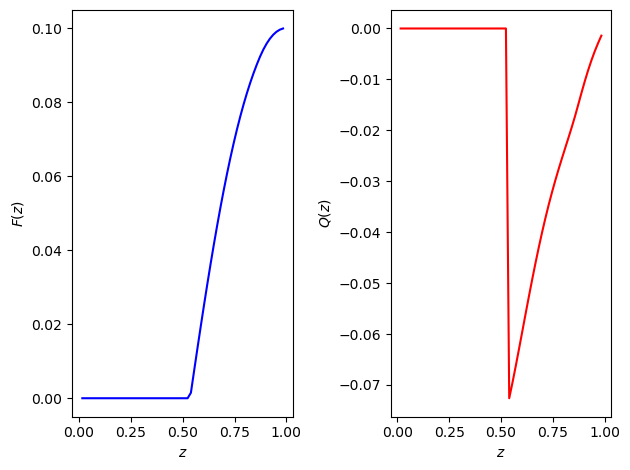

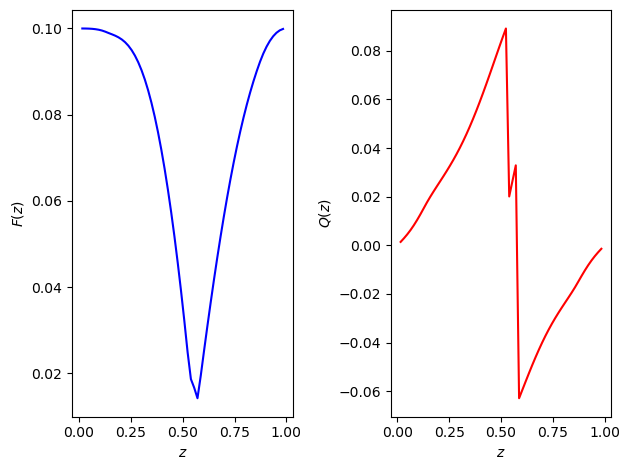

In [5]:
def Plot_F_and_Q(f,q,label_f='$F(z)$',label_q='$Q(z)$'):

  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(z[1:-1], f[1:-1], 'b')
  ax1.set_xlabel(r'$z$')
  ax1.set_ylabel(label_f)
  plt.grid()

  ax2.plot(z[1:-1], q[1:-1], 'r')
  ax2.set_xlabel(r'$z$')
  ax2.set_ylabel(label_q)
  plt.grid()

  plt.tight_layout()
  plt.show()

  return None;


# Initial conditions
Nsq    = 10*z# (z/z)
Plumes = {'F1':.1,'F2':-.1}

Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve(F_value,Nsq)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

Equipped with a means to obtain the velocity field (that is from dividing $Q(z)$ by the horizontal area) we can now combine this with the 1D advection diffusion equation for buoyancy
\begin{equation*}
\frac{\partial b}{\partial t} + \bar{w} \frac{\partial b}{\partial z} = \sigma \frac{\partial^2 b}{\partial z^2},
\end{equation*}
where
\begin{equation*}
\bar{w}(z) = -\frac{1}{A} \sum_i Q_i(z),
\end{equation*}
follows from the fact that $A \bar{w} + \sum_i Q_i(z) = 0$ within the domain (i.e. the flow outside the plumes must be opposite), and $\sigma$ a regularising diffusion. To do solve we implement the advection diffusion equation with and without a regularising diffusion for buoyancy $b(z,t)$ as below

In [6]:
def step_buoyancy(w,b,σ=.1,dt=1e-03,A_inv = None, B = None):

    """
    Step forward using one time-step

    if σ > 0:
    Crank-Nicolson
    elif σ == 0
    Lax-Wendroff

    returns b(z,t_n+1)
    """

    if σ > 0:

      if (A_inv is None) and (B is None):
        A = (I/dt - .5*σ*L)
        B = (I/dt + .5*σ*L)
        return np.linalg.solve(A,B@b - w*(D@b) )
      else:
        return A_inv@( B@b - w*(D@b) )

    elif σ == 0:

      #Courant number |c*dt/dx| < 1
      c = np.max(abs(w))
      while  (c*dt)/dz > 1.:
        dt *=0.5

      return b - dt*w*(D@b)

With a solver developed for the plume equations and for the 1D buoyancy equations we now link these routines together to establish the background stratification profile for a given set of plume sources and sinks. We consider the case of two opposing plumes of equal strength.

We first specify initial conditions for the rising plume
\begin{align}
  F_1(z=0) &= .1, \\
  Q_1(z=0) &= 0, \\
  M_1(z=0) &= 0,
\end{align}
the sinking plume
\begin{align}
  F_2(z=1) &=-.1, \\
  Q_2(z=1) &= 0, \\
  M_2(z=1) &= 0,
\end{align}
and the initial stratification
\begin{equation}
  db/dz(z,t_0=0) = 1.
\end{equation}
Using these boundary conditions we then:
- Solve the plume equations using $db/dz(z,t_n)$ for each of the plumes to obtain $Q_i^n$
- Compute $\bar{w}(z,t_n)$ from the sum of the plumes' volume fluxes $Q_i^n$
- Timestep the 1D buoyancy equation forward from $t_n \to t_n + dt$ to update $db/dz(z,t_n)$ \\

This process is repeated until the residual error
\begin{equation}
  || db^{n+1}/dz - db^{n}/dz ||_2/||db^{n}/dz || < \text{tol},
\end{equation}
falls below a user prescribed tolerance.

/tmp/ipykernel_9611/702643224.py:5: RuntimeWarning: invalid value encountered in scalar power
  α    = -(3/8)*δ + (1/4)*( (F * Q**2)/M**2.5 )
/tmp/ipykernel_9611/702643224.py:8: RuntimeWarning: invalid value encountered in scalar power
  dQdz = 2*α*np.sqrt(np.pi)*(M**0.5)


Iteration i = 1000, Residual error r_i = 1.910826e-04 

Iteration i = 2000, Residual error r_i = 2.098818e-04 

Iteration i = 3000, Residual error r_i = 1.805864e-04 

Iteration i = 4000, Residual error r_i = 1.623573e-04 

Iteration i = 5000, Residual error r_i = 1.119010e-04 

Iteration i = 6000, Residual error r_i = 1.289733e-04 

Iteration i = 7000, Residual error r_i = 9.033581e-05 

Iteration i = 8000, Residual error r_i = 7.095024e-05 

Iteration i = 9000, Residual error r_i = 3.452680e-04 

Iteration i = 10000, Residual error r_i = 6.384848e-04 



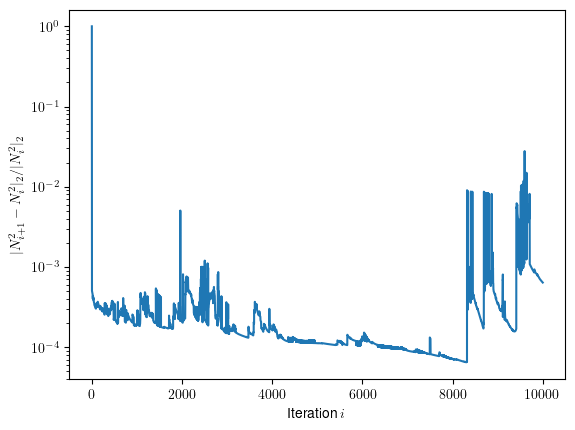

In [21]:
# Sources and IC
b      = 10*z # the solver remains more stable with a larger stratification
Nsq    = D@b;
Plumes = {'F1':.5,'F2':-.5}
#Plumes = {'F1':0.1,'F2':0.05,'F3':-0.15} # We can try more plumes but this is more difficult to converge
Area   = 1.0

σ     = 5e-04
dt    = 1e-03
A_inv = np.linalg.inv(I/dt - .5*σ*L)
B     = (I/dt + .5*σ*L)

W_frames = []
B_frames = []

# (4) Grab the frames
W_frames.append(0*b[1:-1])
B_frames.append(b[1:-1])

Error = [1.0];
iter  = 0;
while (iter < 10**4): #(Error[-1] > 1e-03) or

  # (1) solve plume equations
  w = 0*z
  for F_key,F_value in Plumes.items():
    Q_i= Plume_Solve(F_value,Nsq)[1]
    w -= Q_i/Area

  # (2) step db/dt forward
  b = step_buoyancy(w,b,σ=σ,dt=dt,A_inv=A_inv,B=B)

  # (3) update N^2 & check converged
  Error.append(  np.linalg.norm(Nsq - D@b,2)/np.linalg.norm(Nsq,2) )
  Nsq   = D@b;
  iter += 1.

  if iter%1000 ==0:
    print('Iteration i = %d, Residual error r_i = %e \n'%(iter,Error[-1]))
    #Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')

  # (4) Grab the frames
  W_frames.append(w[1:-1])
  B_frames.append(b[1:-1])

plt.ylabel(r'$|N^2_{i+1} - N^2_i|_2/|N^2_i|_2$')
plt.xlabel(r'Iteration $i$')
plt.semilogy(Error)
plt.show()

Having converged to a steady state for $b(z)$ and $\bar{w}(z)$ we then plot the time evolution of the flow to this steady state below

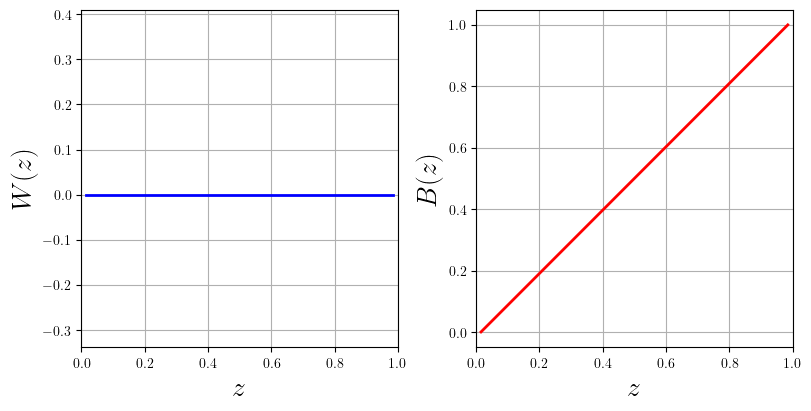

In [22]:
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "sans-serif", "font.sans-serif": "Helvetica"})
from matplotlib.animation import FuncAnimation

# Setup the figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), layout='constrained')

ax1.set_xlabel(r'$z$', fontsize=20)
ax1.set_ylabel(r'$W(z)$', fontsize=20)
ax1.set_xlim([0, 1])
#ax2.set_ylim([-.1, .1])
ax1.grid(True)

ax2.set_xlabel(r'$z$', fontsize=20)
ax2.set_ylabel(r'$B(z)$', fontsize=20)
ax2.set_xlim([0, 1])
#ax2.set_ylim([2, 8])
ax2.grid(True)

def animation_function(i):
  
  for line in ax1.get_lines():
    line.remove()
  line1 = ax1.plot(z[1:-1], W_frames[i], 'b', linewidth=2)
  
  for line in ax2.get_lines():
    line.remove()
  line2 = ax2.plot(z[1:-1], (B_frames[i] - np.min(B_frames[i]))/(np.max(B_frames[i]) - np.min(B_frames[i])), 'r', linewidth=2)
  
  return line1, line2

anim = FuncAnimation(fig=fig,func=animation_function, frames=np.arange(0,len(W_frames),100))
anim.save('Part1_Plume_SIM.mp4',fps=10)

The animation shows the system gradually converging to a two layer stratification as expected. This however does not take place without some difficulties, which we notice towards the end of the video. Notably the initial stratification must be strong enough or else the system tends to a trivial solution. In addition the more plumes we add the more difficult it is to converge the system. Furthermore, the solutions are discontinuous even though physically unrealistic.